# Estimate persistence times

How long do viruses circulate in domestic prior to infecting humans? How long do viruses persist in domestic after transmission from wild? This notebook will attempt to answer those questions.

In [26]:
import glob
import re,copy, imp
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '/Users/lmoncla/src/baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

import time
from io import StringIO

import rpy2
%load_ext rpy2.ipython

In [2]:
from datetime import date
current_date = str(date.today())

In [3]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

In [4]:
def get_taxa_lines(tree_path):    
    # write out a temp tree file
#     temp_tree = tree_path.replace(".trees",".temp.tree")
#     with open(temp_tree, "w") as outfile: 
#         outfile.write("")

    lines_to_write = ""
    with open(tree_path, 'rU') as infile:
        for line in infile: ## iterate through each line
            if 'state' not in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                lines_to_write = lines_to_write + line

    return(lines_to_write)

In [5]:
def get_burnin_value(tree_path, burnin_percent):
    with open(tree_path, 'rU') as infile:
        numtrees = 0
        for line in infile: ## iterate through each line
            if 'state' in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                numtrees += 1
    
    burnin = numtrees * burnin_percent
    return(burnin)

In [14]:
# trees file paths
constant_human_on = {"label": "constant-human-on","mig_direction":"backwards in time",
    "trees":"beast-runs/2021-03-15-mascot-3deme-constant/with-human-mig/3deme-mascot-constant-with-human-mig-2021-03-15.combined.trees"}
constant_human_off = {"label": "constant-human-off","mig_direction":"backwards in time",
    "trees":"beast-runs/2021-03-15-mascot-3deme-constant/no-human-mig/3deme-mascot-constant-no-human-mig-2021-03-15.combined.trees"}
skyline_human_on =  {"label": "skyline-human-on", "mig_direction":"forwards in time",
                     "trees": "beast-runs/2021-03-15-mascot-3deme-skyline-with-mig-history/with-human-mig/2021-04-27-mascot-3deme-skyline-with-human-mig.combined.trees"}
skyline_human_off = {"label": "skyline-human-off", "mig_direction":"forwards in time",
                     "trees": "beast-runs/2021-07-26-mascot-3deme-skyline-with-mig-fixed-log/it1/2021-07-06-mascot-3deme-skyline-tipdates.muts.trees"}

In [15]:
to_run = skyline_human_off

trees_file_path = to_run['trees']
label = to_run['label']

burnin_percent = 0.1

In [16]:
all_trees = trees_file_path
burnin_percent = 0.1

taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

29.200000000000003


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 'U' mode is deprecated
  
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 'U' mode is deprecated
  


In [17]:
def find_human_tips(tree):
    
    df_to_return = pd.DataFrame()
    
    for k in tree.Objects: 
        if k.branchType == "leaf":
            if k.traits['typeTrait'] == 'human':
                branch_length_avian = 0
                region = k.name.split("|")[4]
                
                parent, parent_type, branch_length_avian = compute_domestic_branch_length(k, branch_length_avian)
                
                local_df = pd.DataFrame.from_dict({"tip":[k.name], 
                                                   "time_in_domestic":branch_length_avian,
                                                  "region":region})
                df_to_return = df_to_return.append(local_df)
                
                
    return(df_to_return)

In [18]:
def compute_domestic_branch_length(tip, cumulative_branch_length):
    
    parent = tip.parent
    parent_branch_length = parent.length
    
    if 'typeTrait' in parent.traits:
        parent_type = parent.traits['typeTrait']
    else:
        parent_type = "unknown"
    
    if parent_type == 'domestic':
        cumulative_branch_length += parent_branch_length
        node, node_type, cumulative_branch_length = compute_domestic_branch_length(parent, cumulative_branch_length)
        
    else:
        node, node_type = parent, parent_type
    
    return(node, node_type, cumulative_branch_length)

In [38]:
start_time = time.time()

with open(all_trees, "r") as infile:
    
    df = pd.DataFrame()
    tree_counter = 0
    trees_processed = 0
    migrations_dict = {}
    
    for line in infile:
        if 'tree STATE_' in line:
            tree_counter += 1
            
            if tree_counter > burnin:
                trees_processed += 1
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree)
                tree.setAbsoluteTime(2019.227)
                
                # run stuff
                local_df = find_human_tips(tree)
                local_df['tree_number'] = tree_counter
                df = df.append(local_df)

# print the amount of time this took
total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds/60
print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")

this took 82.74606895446777 seconds ( 1.3791011492411296  minutes) to run on 263 trees


In [39]:
df.head()

,tip,time_in_domestic,region,tree_number
0,A/Alberta/1/2014|2014.005|2014-01-03|Human|Nor...,0.228322,North_America,30
0,A/Nanjing/1/2015|2015.055|2015-01-21|Human|Chi...,5.811492,China,30
0,A/Hubei/1/2010|2010.384|2010-05-21|Human|China...,1.200913,China,30
0,A/Vietnam/CM32/2011|2011.797|2011-10-19|Human|...,1.820172,Southeast_Asia,30
0,A/Nepal/19FL1997/2019|2019.227|2019-03-25|Huma...,0.204182,South_Asia,30


In [21]:
print(len(df))
df = df[df['time_in_domestic'] > 0]
print(len(df))

32875
26168


In [40]:
df['time_in_domestic'].mean()

3.3031512079989813

In [41]:
df['time_in_domestic'].std()

3.253827885971054

In [42]:
df['time_in_domestic'].median()

2.418342102138702

In [46]:
import pymc3
pymc3.stats.hpd(df['time_in_domestic'], 0.95)

array([0.        , 9.72452269])

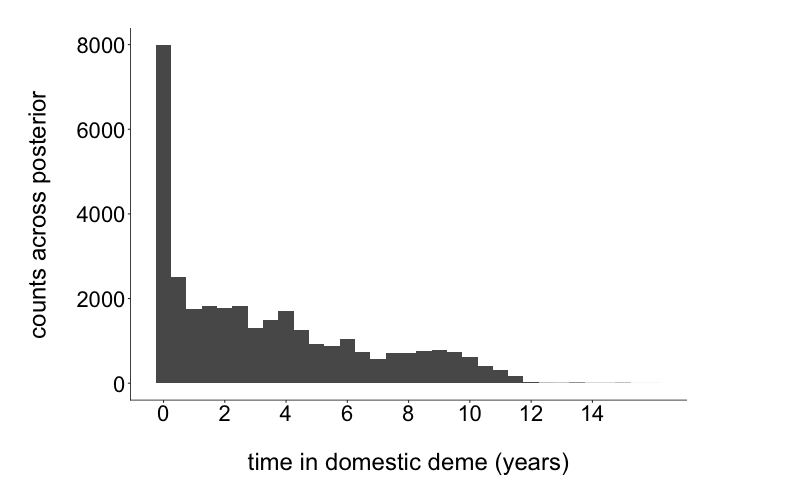

In [47]:
%%R -w 800 -h 500 -u px -i df,label,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("persistence-times-",label,"-",current_date,".pdf", sep="")

p <- ggplot(data=df, aes(x=time_in_domestic)) + 
    geom_histogram(binwidth=0.5)+
    #facet_wrap(~region)+
    #geom_point(size=1, alpha=0.6)+
    #geom_boxplot()+
    #geom_line(stat="count")+
    labs(x="\ntime in domestic deme (years)", y="counts across posterior\n")+
    #scale_y_continuous(breaks=seq(0,0.2,0.05), limits=c(0,0.2))+
    scale_x_continuous(breaks=seq(0,15,2))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

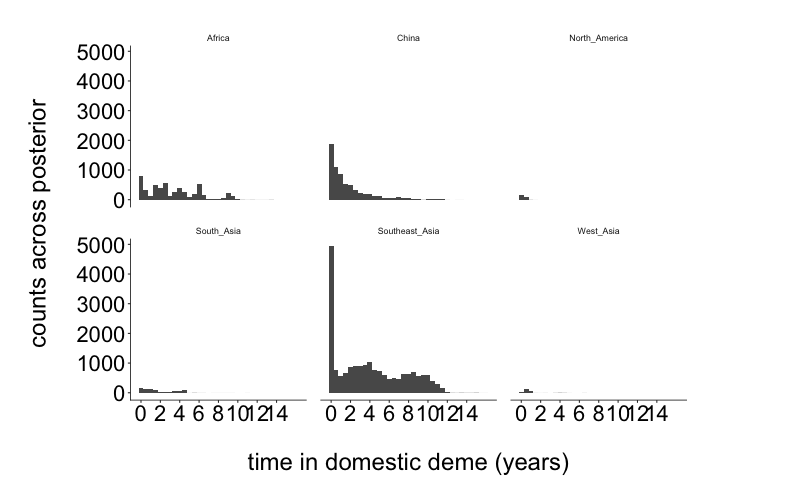

In [51]:
%%R -w 800 -h 500 -u px -i df,label,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("persistence-times-by-region-",label,"-",current_date,".pdf", sep="")

p <- ggplot(data=df, aes(x=time_in_domestic)) + 
    geom_histogram(binwidth=0.5)+
    facet_wrap(~region)+
    #geom_point(size=1, alpha=0.6)+
    #geom_boxplot()+
    #geom_line(stat="count")+
    labs(x="\ntime in domestic deme (years)", y="counts across posterior\n")+
    #scale_y_continuous(breaks=seq(0,0.2,0.05), limits=c(0,0.2))+
    scale_x_continuous(breaks=seq(0,15,2))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 12, height = 6, device = "pdf", path = "figures", dpi = 300)
p

In [88]:
"""enumerate host transitions on the tree"""

def retrieve_subtrees(tree, traitName, donor_deme, recipient_deme):
    
    tree.root.traits[traitName]='ancestor' 

    for k in sorted(tree.Objects,key=lambda x:x.height):

        deme = k.traits[traitName].lower().replace(" ","_")   
        
        # pull parent deme
        if traitName in k.parent.traits:  # if parent has a trait block, use that trait, else assign to ancestor
            parent_deme=k.parent.traits[traitName].lower().replace(" ","_")     # kploc = trait of parental node
        else:
            parent_deme='ancestor'

        # if a host switch is occurring
        if deme == recipient_deme and parent_deme == donor_deme:
            traverse_condition=lambda w:w.traits[traitName].lower().replace(" ","_")==deme     # traverse tree for all nodes whose traitname = kc
#             print('subtree resulting from '+parent_deme+' > '+deme+' switch, traversing within '+ deme)

            subtree=tree.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            
            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()
                if deme in subtype_trees:
                    subtype_trees[deme].append((parent_deme,subtree))
                else:
                    subtype_trees[deme] = []
                    subtype_trees[deme].append((parent_deme,subtree))
                    
    return(subtype_trees)

In [94]:
def output_cluster_times(subtype_trees, recipient_deme):
    cluster_times = {recipient_deme: []}
    
    for subtree in subtype_trees[recipient_deme]:
        dates = []
        trans_from = subtree[0]
        tree = subtree[1]
            
        for k in tree.Objects: 
            if k.branchType == "leaf":
                # pull the date
                date = float(k.name.split("|")[1])
            elif k.branchType == "node":
                date = k.absoluteTime
            dates.append(date)
                
        minimum_date = min(dates)
        maximum_date = max(dates)
        date_range = maximum_date - minimum_date
            
        cluster_times[recipient_deme].append(date_range)

    return(cluster_times)

In [95]:
start_time = time.time()
hosts_list = ["wild"]

with open(all_trees, "r") as infile:
    
    df = pd.DataFrame()
    tree_counter = 0
    trees_processed = 0
    migrations_dict = {}
    
    for line in infile:
        if 'tree STATE_' in line:
            tree_counter += 1
            
            if tree_counter > burnin and tree_counter < 31:
                trees_processed += 1
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree)
                tree.setAbsoluteTime(2019.227)
                
                # run stuff
                subtype_trees = retrieve_subtrees(tree, "typeTrait", "wild","domestic")
                cluster_times = output_cluster_times(subtype_trees, "domestic")
#                 local_df = pd.DataFrame.from_dict(cluster_times)
#                 local_df['tree_number'] = tree_counter
#                 df = df.append(local_df)

# print the amount of time this took
total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds/60
print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")

this took 16.07880926132202 seconds ( 0.26798015435536704  minutes) to run on 1 trees


In [96]:
subtype_trees

{'wild': [('ancestor', <baltic.tree at 0x7fa402c8b390>),
  ('domestic', <baltic.tree at 0x7fa4108b9c50>),
  ('domestic', <baltic.tree at 0x7fa4023720b8>),
  ('domestic', <baltic.tree at 0x7fa4035a9a58>),
  ('domestic', <baltic.tree at 0x7fa403227fd0>),
  ('domestic', <baltic.tree at 0x7fa41402c5c0>),
  ('domestic', <baltic.tree at 0x7fa40346b748>)],
 'domestic': [('wild', <baltic.tree at 0x7fa40361c940>),
  ('wild', <baltic.tree at 0x7fa414a007f0>),
  ('wild', <baltic.tree at 0x7fa400779358>),
  ('wild', <baltic.tree at 0x7fa3ff81f6d8>),
  ('wild', <baltic.tree at 0x7fa3ff355518>),
  ('wild', <baltic.tree at 0x7fa414492eb8>),
  ('wild', <baltic.tree at 0x7fa3ffe0e278>),
  ('wild', <baltic.tree at 0x7fa4010c0358>),
  ('wild', <baltic.tree at 0x7fa400173d30>),
  ('wild', <baltic.tree at 0x7fa40329be48>),
  ('wild', <baltic.tree at 0x7fa40354e668>),
  ('wild', <baltic.tree at 0x7fa402e6c668>),
  ('wild', <baltic.tree at 0x7fa41050f4a8>),
  ('wild', <baltic.tree at 0x7fa41344f3c8>),
  ('wi

In [97]:
cluster_times

{'domestic': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  10.218590884150217,
  0.3662454304133007,
  1.0,
  9.910338859512649,
  0.0,
  0.0,
  2.878546836664782,
  0.20114148344418936,
  0.0,
  6.4975271274529405,
  6.888403284104925,
  2.2401779581853134,
  6.382807517441506,
  1.425599535884885,
  0.20574219588229425,
  1.99658002301112,
  0.2415927289098363,
  0.0,
  0.0,
  0.36999999999989086,
  0.9058255351517346,
  0.2929999999998927,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  3.9260915946231307,
  0.0,
  0.46299999999996544,
  0.0,
  0.0,
  0.0,
  2.2742392244788334,
  0.3856289293946702,
  0.0,
  6.32097318889555,
  0.0,
  0.0,
  0.0,
  0.0,
  3.8861308033717705,
  0.0,
  1.6878428186225847,
  0.0,
  0.0,
  0.37127364902244153,
  0.0,
  0.8485033620033846,
  6.094896119777559,
  3.1752737911087934,
  0.0,
  0.0,
  0.0,
  0.0,
  1.9313380898327068,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  3.7296160844766746,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0

In [157]:
def return_persistence_times(tree, return_dict):
            
    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k
        
        if 'max' in k.traits:
            host = k.traits['max']
        else:
            host = 'ancestor'
        
        if k.branchType == "node":
            children = k.children
            
            ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            traverse_condition=lambda w:w.traits['max'].lower().replace()==kloc
            subtree=tree.subtree(k,traverse_condition=traverse_condition) 


In [158]:
hosts_dict = {'human':[],'domestic':[],'wild':[]}
return_persistence_times(tree, hosts_dict)

[<baltic.node object at 0x7fb1c3d19f28>, <baltic.node object at 0x7fb1c6c065f8>]
[<baltic.node object at 0x7fb1c3d19ef0>, <baltic.node object at 0x7fb1c6c062b0>]
[<baltic.node object at 0x7fb1dc6f1400>, <baltic.node object at 0x7fb1da3c4710>]
[<baltic.node object at 0x7fb1c3483470>, <baltic.node object at 0x7fb1dfd05630>]
[<baltic.node object at 0x7fb1c69f2f28>, <baltic.node object at 0x7fb1dfd05198>]
[<baltic.node object at 0x7fb1dacade80>, <baltic.node object at 0x7fb1c72317f0>]
[<baltic.node object at 0x7fb1c3670400>, <baltic.node object at 0x7fb1c7231ef0>]
[<baltic.leaf object at 0x7fb1c20c0f28>, <baltic.node object at 0x7fb1c72319b0>]
[<baltic.node object at 0x7fb1c2bdfb00>, <baltic.node object at 0x7fb1c3309eb8>]
[<baltic.node object at 0x7fb1c2e5ada0>, <baltic.node object at 0x7fb1c0484320>]
[<baltic.node object at 0x7fb1c698c160>, <baltic.node object at 0x7fb1c04841d0>]
[<baltic.node object at 0x7fb1c698cb70>, <baltic.node object at 0x7fb1c802add8>]
[<baltic.node object at 0x7f

In [ ]:
from io import StringIO
import time
start_time = time.time()

with open(all_trees, "r") as infile:
    
    tree_counter = 0
    
    for line in infile:
        if 'tree STATE_' in line:
            tree_counter += 1
            if tree_counter > burnin:
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree)
                print(tree)

                hosts_list = ['human','wild','domestic']
                subtype_trees = retrieve_subtrees(tree)
                cluster_times_dict = output_cluster_times(subtype_trees)
            
print("My program took", time.time() - start_time, "to run")